<a href="https://colab.research.google.com/github/jaxpacleb/time-series-forecasting-LSTM/blob/main/Time_Series_Forecasting_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


92/92 - 2s - 21ms/step - loss: 0.0332
Epoch 2/100
92/92 - 0s - 4ms/step - loss: 0.0134
Epoch 3/100
92/92 - 1s - 7ms/step - loss: 0.0103
Epoch 4/100
92/92 - 1s - 7ms/step - loss: 0.0088
Epoch 5/100
92/92 - 0s - 4ms/step - loss: 0.0076
Epoch 6/100
92/92 - 0s - 3ms/step - loss: 0.0065
Epoch 7/100
92/92 - 0s - 3ms/step - loss: 0.0056
Epoch 8/100
92/92 - 0s - 2ms/step - loss: 0.0050
Epoch 9/100
92/92 - 0s - 2ms/step - loss: 0.0045
Epoch 10/100
92/92 - 0s - 2ms/step - loss: 0.0041
Epoch 11/100
92/92 - 0s - 3ms/step - loss: 0.0039
Epoch 12/100
92/92 - 0s - 3ms/step - loss: 0.0038
Epoch 13/100
92/92 - 0s - 2ms/step - loss: 0.0037
Epoch 14/100
92/92 - 0s - 2ms/step - loss: 0.0036
Epoch 15/100
92/92 - 0s - 2ms/step - loss: 0.0035
Epoch 16/100
92/92 - 0s - 3ms/step - loss: 0.0035
Epoch 17/100
92/92 - 0s - 2ms/step - loss: 0.0034
Epoch 18/100
92/92 - 0s - 2ms/step - loss: 0.0034
Epoch 19/100
92/92 - 0s - 2ms/step - loss: 0.0034
Epoch 20/100
92/92 - 0s - 2ms/step - loss: 0.0033
Epoch 21/100
92/92 -

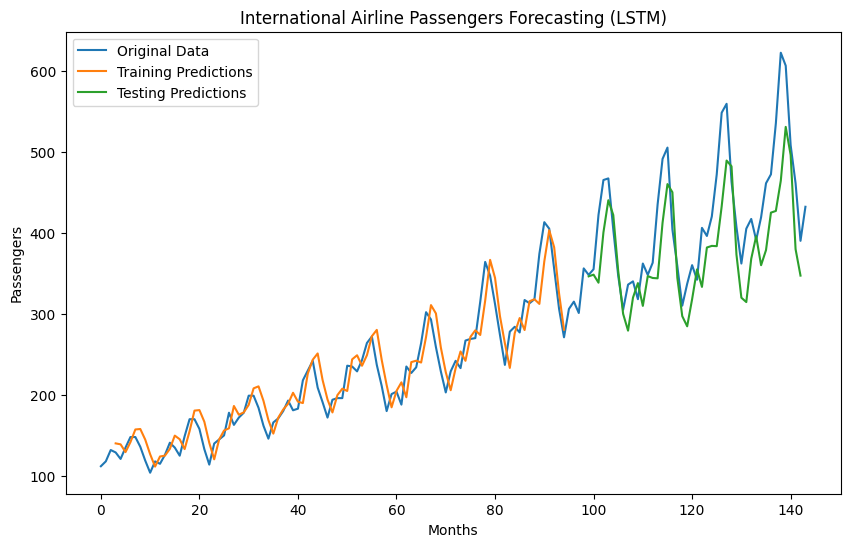

In [ ]:
#MEMBERS: GERMIN P. PACLEB - DANIEL EDISON GANADO - RICHARD SCOTT RICOHERMOSO - SEBASTIAN KIRT C DOCTOR
#TIME SERIES FORECASTING WITH LSTM
#SECTION: BSCS 3B



import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import math

# 1. SET RANDOM SEED FOR REPRODUCIBILITY
tf.random.set_seed(42)
np.random.seed(42)

# 2. LOAD THE DATASET
# We use a direct URL to the raw CSV file hosted on GitHub
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
dataframe = pd.read_csv(url, usecols=[1], engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32')

# 3. PREPROCESSING
# Normalize the dataset (LSTMs work better with data scaled between 0 and 1)
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# Split into train and test sets (67% train, 33% test)
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train_data, test_data = dataset[0:train_size, :], dataset[train_size:len(dataset), :]

# Helper function to create a sliding window dataset
# X = current time step(s), Y = next time step
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

# Reshape into X=t and Y=t+1
look_back = 3 # We look at the previous 3 months to predict the next month
trainX, trainY = create_dataset(train_data, look_back)
testX, testY = create_dataset(test_data, look_back)

# Reshape input to be [samples, time steps, features] required for LSTM
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

# 4. BUILD THE LSTM MODEL
model = Sequential()
# Input shape: (1 time step, 'look_back' features)
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# 5. TRAIN THE MODEL
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

# 6. MAKE PREDICTIONS
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# 7. INVERSE TRANSFORM PREDICTIONS
# We invert the scaling to get back to the actual number of passengers
trainPredict = scaler.inverse_transform(trainPredict)
trainY_inverse = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY_inverse = scaler.inverse_transform([testY])

# 8. CALCULATE PERFORMANCE (RMSE)
from sklearn.metrics import mean_squared_error
trainScore = math.sqrt(mean_squared_error(trainY_inverse[0], trainPredict[:,0]))
print(f'Train Score: {trainScore:.2f} RMSE')
testScore = math.sqrt(mean_squared_error(testY_inverse[0], testPredict[:,0]))
print(f'Test Score: {testScore:.2f} RMSE')

# 9. VISUALIZATION
# Shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# Shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# Plot baseline and predictions
plt.figure(figsize=(10,6))
plt.plot(scaler.inverse_transform(dataset), label='Original Data')
plt.plot(trainPredictPlot, label='Training Predictions')
plt.plot(testPredictPlot, label='Testing Predictions')
plt.title('International Airline Passengers Forecasting (LSTM)')
plt.xlabel('Months')
plt.ylabel('Passengers')
plt.legend()
plt.show()